In [12]:
% matplotlib inline
import bidict
import os
import csv
import scipy.sparse
import numpy as np
import random
import matplotlib.pyplot as plt
import chesicl.data_loading.load_constraints as load_data
from blessings import Terminal
term = Terminal()
print term.blue('kotek')

kotek


In [5]:
# constants
data_folder = '/var/data/users/local/pocha/data/SCFP'
similarity_file = os.path.join(data_folder, 'Similarity150Dawid.csv')
all_compounds_file = os.path.join(data_folder, 'Random_compounds_100.sdf')
folder_with_pairs = os.path.join(data_folder, 'pairs')
n_sets = 10

possible_compounds = 'possible compounds'
pairs_contained = 'pairs contained'
probability = 'probability'
compounds_contained = 'compounds contained'
size = 'size'

In [6]:
def clustering_score(clusters, n_omitted):
    # chcemy niską wariancję i mało pominiętych par
    assert isinstance(clusters, list), 'clusters should be a non-empty list of dictionaries'
    assert len(clusters) > 0, 'clusters should be a non-empty list of dictionaries'
    assert isinstance(clusters[0], dict), 'clusters should be a non-empty list of dictionaries'
    variance = 0
    if pairs_contained in clusters[0].keys():
        variance = np.var([float(len(cluster[pairs_contained]))/(cluster[probability][1]-cluster[probability][0])
                       for cluster in clusters])
    elif size in clusters[0].keys():
        variance = np.var([float(cluster[size])/(cluster[probability][1]-cluster[probability][0])
                       for cluster in clusters])
    else:
        raise KeyError('either `'+size+'` or `'+pairs_contained+'` must be in clusters')
    score = (5./8)*variance + n_omitted
    return score, variance # TODO 30 - powinno byc wiecej, bo klastrow bedzie mniej

In [14]:
def agnieszka_folds(all_compunds_file, folder_with_pairs):
    best_clusterings = []
    best_score = 10**4
    scores = []
    variances = []
    n_ommited_pairs = []
    while(True): # many times
        bin_sim, _, mapping_idx_chembl = load_data.load_similarity_matrices(similarity_file, all_compunds_file, folder_with_pairs)
        bin_sim.setdiag(np.zeros((bin_sim.shape[0]))) # pairs (i,i) are not interesting for us
        pairs = zip(bin_sim.nonzero()[0], bin_sim.nonzero()[1])
                
        random.shuffle(pairs)
        clusters = [{possible_compounds:list(mapping_idx_chembl.keys()), pairs_contained:[]} for i in xrange(2)]
        clusters[0][probability], clusters[1][probability] = (0.0, 0.9), (0.9, 1.0)
        failures = 0
        max_failures = len(pairs)
        try:
            while failures < max_failures:
                i, j = pairs.pop() # popping random pair
                if i > j:
                    continue # saving time
                
                x = np.random.rand()
                for cluster in clusters:  # iterating over clusters to find the chosen one
                    if cluster[probability][0] <= x < cluster[probability][1]:  # if the cluster was chosen
                        # if pair might go inside
                        if i in cluster[possible_compounds] and j in cluster[possible_compounds]:
                            failures = 0
                            cluster[pairs_contained].append((i,j))
                            
                            # usun zwiazki i, j z mozliwych w kazdym klastrze poza obecnym
                            for c in clusters:
                                if i in c[possible_compounds]:
                                    c[possible_compounds].remove(i)
                                if j in c[possible_compounds]:
                                    c[possible_compounds].remove(j)
                            cluster[possible_compounds].extend([i, j])
                        else: # the cluster was chosen but we cannot fit the pair there
                            failures += 1
                            pairs.insert(0, (i, j)) # pair goes back to the poll
                        break # we've found the chosen one
                
        except IndexError:  # zbior par jest pusty
            print term.green('index error')
            pass
        finally:
            # wyszlismy z while'a, wiec albo mamy wpasowane wszystkie pary albo mielismy 100 porazek
            omitted_pairs = len(pairs)
            score, variance = clustering_score(clusters, omitted_pairs)
            
            # TODO: new score needed
            print 'score', score
            print 'omitted_pairs', omitted_pairs
            if score < best_score:
                print '\n'
                
                best_score = score
                best_clusterings.append(clusters)
                if len(best_clusterings) > n_sets:
                    best_clusterings = best_clusterings[-n_sets:]
                scores.append(best_score)
                variances.append(variance)
                n_ommited_pairs.append(omitted_pairs)
                plt.plot(range(len(scores)), scores, c='r')
                plt.plot(range(len(variances)), variances, c='g')
                plt.plot(range(len(n_ommited_pairs)), n_ommited_pairs, c='b')
                plt.title('best score over time')
                plt.show()
                print "score", score, 'variance', variance, 'omitted_pairs', omitted_pairs
                print 'wielkości klastrów', [len(cluster[pairs_contained]) for cluster in clusters]
                print 'pominietych par', omitted_pairs
                print "#BEST CLUSTERING\n", best_clusterings[-1]

    
            print '_________________________________________________\n'
    
    return best_clusterings

21 pairs were omitted
score 19436.4521605
omitted_pairs 52
_________________________________________________



/home/pocha/libs/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


21 pairs were omitted
score 24218.6111111
omitted_pairs 45
_________________________________________________

21 pairs were omitted
score 31499.5679012
omitted_pairs 15
_________________________________________________

21 pairs were omitted
score 25743.2669753
omitted_pairs 44
_________________________________________________

21 pairs were omitted
score 13228.625
omitted_pairs 88
_________________________________________________

21 pairs were omitted
score 23659.4012346
omitted_pairs 29
_________________________________________________

21 pairs were omitted
score 31654.625
omitted_pairs 14
_________________________________________________

21 pairs were omitted
score 18125.5
omitted_pairs 63
_________________________________________________

21 pairs were omitted
score 20929.8225309
omitted_pairs 50
_________________________________________________

21 pairs were omitted
score 18360.382716
omitted_pairs 61
_________________________________________________

21 pairs were omitted
sco

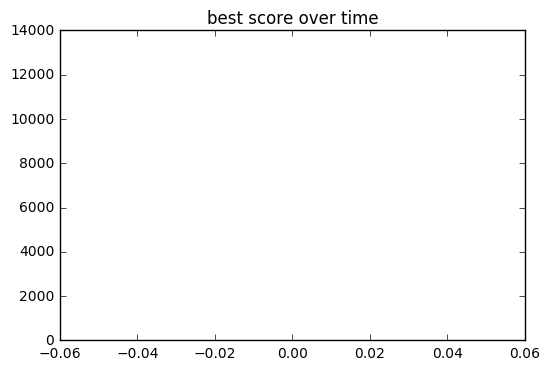

score 7968.14197531 variance 12593.8271605 omitted_pairs 97
wielkości klastrów [319, 13]
pominietych par 97
#BEST CLUSTERING
[{'possible compounds': [13, 68, 69, 23, 92, 87, 66, 26, 64, 90, 8, 99, 84, 97, 29, 61, 38, 72, 50, 74, 83, 49, 89, 31, 91, 14, 57, 27, 77, 45, 43, 4, 88, 48, 16, 78, 95, 60, 25, 11, 98, 62, 94, 41, 76, 33, 59, 42, 1, 34, 7, 21, 56, 86, 58, 96, 46, 81, 53, 20, 79, 93, 22, 51, 40, 39, 3, 65, 82, 6, 19, 37, 80, 5, 24, 73, 30, 47, 52, 2, 17, 18, 85, 71, 75, 54, 55], 'probability': (0.0, 0.9), 'pairs contained': [(55, 78), (20, 54), (53, 84), (8, 39), (2, 85), (80, 84), (5, 18), (55, 81), (42, 95), (62, 84), (39, 40), (29, 80), (57, 98), (30, 80), (16, 51), (1, 29), (30, 43), (75, 88), (7, 56), (74, 88), (20, 75), (51, 69), (37, 75), (49, 87), (65, 92), (8, 89), (34, 69), (19, 84), (24, 57), (38, 75), (82, 92), (11, 64), (22, 72), (30, 65), (42, 66), (5, 50), (42, 91), (1, 72), (4, 51), (25, 99), (7, 34), (31, 75), (30, 95), (53, 97), (58, 65), (3, 56), (3, 53), (50,

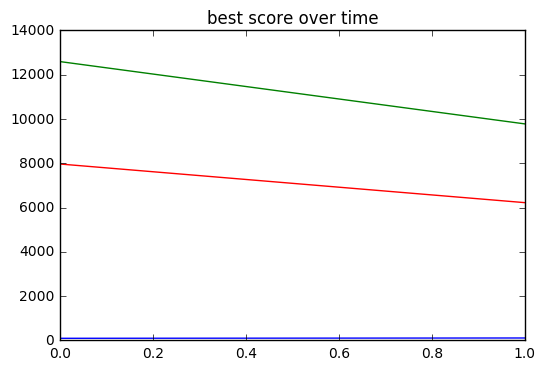

score 6222.88271605 variance 9779.01234568 omitted_pairs 111
wielkości klastrów [304, 14]
pominietych par 111
#BEST CLUSTERING
[{'possible compounds': [13, 90, 64, 92, 66, 21, 83, 67, 77, 14, 89, 46, 69, 32, 8, 93, 56, 81, 41, 79, 96, 39, 25, 88, 59, 70, 4, 85, 26, 53, 52, 16, 97, 60, 84, 86, 65, 1, 49, 55, 62, 94, 78, 68, 73, 47, 10, 50, 74, 3, 5, 27, 71, 72, 12, 33, 80, 98, 29, 76, 87, 28, 36, 58, 37, 17, 20, 40, 42, 38, 57, 7, 9, 95, 45, 51, 15, 22, 11, 48, 2, 63, 0, 34, 24, 99], 'probability': (0.0, 0.9), 'pairs contained': [(28, 98), (16, 69), (4, 55), (1, 15), (77, 80), (11, 27), (3, 56), (29, 80), (16, 59), (42, 88), (24, 62), (20, 86), (4, 83), (28, 96), (84, 97), (29, 33), (2, 27), (56, 64), (3, 38), (70, 86), (11, 64), (7, 99), (62, 79), (12, 48), (48, 66), (59, 88), (37, 51), (21, 32), (22, 67), (63, 68), (55, 78), (38, 60), (2, 85), (27, 95), (9, 73), (78, 95), (50, 76), (24, 57), (10, 89), (4, 39), (15, 86), (11, 21), (39, 40), (45, 57), (22, 36), (46, 81), (32, 33), (58, 

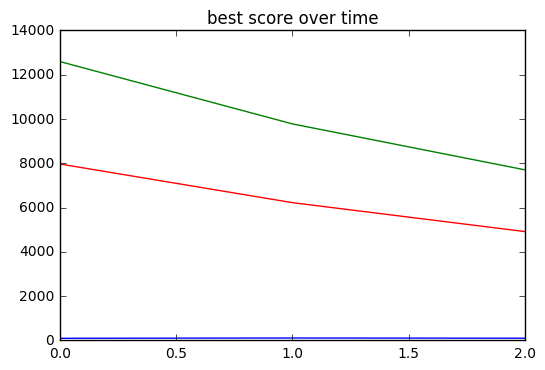

score 4916.58641975 variance 7704.9382716 omitted_pairs 101
wielkości klastrów [311, 17]
pominietych par 101
#BEST CLUSTERING
[{'possible compounds': [13, 98, 36, 26, 18, 83, 90, 47, 0, 4, 55, 28, 87, 41, 49, 66, 21, 1, 81, 7, 34, 50, 27, 71, 17, 23, 76, 24, 14, 54, 25, 46, 74, 37, 89, 67, 95, 5, 92, 91, 19, 82, 15, 59, 88, 8, 35, 61, 77, 43, 33, 3, 29, 79, 22, 70, 30, 85, 38, 60, 40, 42, 12, 58, 2, 99, 53, 97, 6, 94, 48, 62, 9, 10, 16, 65, 80, 72, 78, 68, 69, 73, 96, 44, 52], 'probability': (0.0, 0.9), 'pairs contained': [(10, 89), (2, 24), (0, 72), (58, 65), (37, 79), (90, 97), (78, 95), (29, 91), (4, 70), (5, 73), (36, 80), (5, 65), (4, 83), (37, 96), (19, 77), (6, 44), (3, 38), (36, 48), (73, 90), (3, 30), (12, 88), (59, 65), (22, 94), (28, 47), (82, 91), (7, 61), (24, 85), (9, 15), (14, 72), (27, 49), (27, 60), (4, 85), (15, 82), (30, 80), (27, 44), (2, 62), (80, 88), (3, 34), (30, 43), (12, 48), (5, 18), (77, 80), (10, 82), (9, 96), (25, 74), (60, 91), (55, 78), (5, 82), (71, 80)

KeyboardInterrupt: 

In [15]:
best_clustering = agnieszka_folds(all_compounds_file, folder_with_pairs)

In [16]:
def staszek_folds(similarity_file,all_compounds_file, folder_with_pairs):
    best_clusterings = []
    best_score = 10**4
    scores = []
    variances = []
    n_ommited_pairs = []
    
    while(True): # many times
        bin_sim, _, mapping_idx_chembl = load_data.load_similarity_matrices(similarity_file, all_compounds_file, folder_with_pairs)
        bin_sim.setdiag(np.zeros((bin_sim.shape[0]))) # pairs (i,i) are not interesting for us
        pairs = zip(bin_sim.nonzero()[0], bin_sim.nonzero()[1])
                
        random.shuffle(pairs)
        clusters = [{compounds_contained:[], size:0} for i in xrange(2)]
        clusters[0][probability], clusters[1][probability] = (0.0, 0.9), (0.9, 1.0)
        
        omitted_pairs = 0
        
        for compound_index in xrange(0, len(pairs)):
            x = np.random.rand()
            for cluster in clusters:  # iterating over clusters to find the chosen one
                    if cluster[probability][0] <= x < cluster[probability][1]:  # if the cluster was chosen
                        cluster[compounds_contained].append(compound_index)
                        
        for pair in pairs:
            i, j = pair
            if i > j:
                continue # saving time
                
            contained = False
            for cluster in clusters:
                if i in cluster[compounds_contained] and j in cluster[compounds_contained]:
                    cluster[size] += 1
                    contained=True
                    break
                    
            if not contained:    
                omitted_pairs += 1

        # scoring the clustering found
        score, variance = clustering_score(clusters, omitted_pairs)
        print 'omitted_pairs', omitted_pairs
        print 'score', score
        if score < best_score:
            print '\n'

            best_score = score
            best_clusterings.append(clusters)
            if len(best_clusterings) > n_sets:
                    best_clusterings = best_clusterings[-n_sets:]
            scores.append(best_score)
            variances.append(variance)
            n_ommited_pairs.append(omitted_pairs)
            plt.plot(range(len(scores)), scores, c='r')
            plt.plot(range(len(variances)), variances, c='g')
            plt.plot(range(len(n_ommited_pairs)), n_ommited_pairs, c='b')
            plt.title('best score over time')
            plt.show()
            print "score", score, 'variance', variance, 'omitted_pairs', omitted_pairs
            print 'wielkości klastrów', [cluster[size] for cluster in clusters]
            print 'pominietych par', omitted_pairs
            print "#BEST CLUSTERING\n", best_clusterings[-1]

    
        print '_________________________________________________\n'
    
    return best_clusterings

21 pairs were omitted
omitted_pairs 109
score 15232.4567901
_________________________________________________

21 pairs were omitted
omitted_pairs 57
score 23958.2345679
_________________________________________________

21 pairs were omitted
omitted_pairs 59
score 25059.0
_________________________________________________

21 pairs were omitted
omitted_pairs 73
score 19335.345679
_________________________________________________

21 pairs were omitted
omitted_pairs 59
score 23689.4012346
_________________________________________________

21 pairs were omitted
omitted_pairs 104
score 14692.1558642
_________________________________________________

21 pairs were omitted
omitted_pairs 53
score 23146.3641975
_________________________________________________

21 pairs were omitted
omitted_pairs 69
score 22368.382716
_________________________________________________

21 pairs were omitted
omitted_pairs 105
score 11589.5679012
_________________________________________________

21 pairs were o

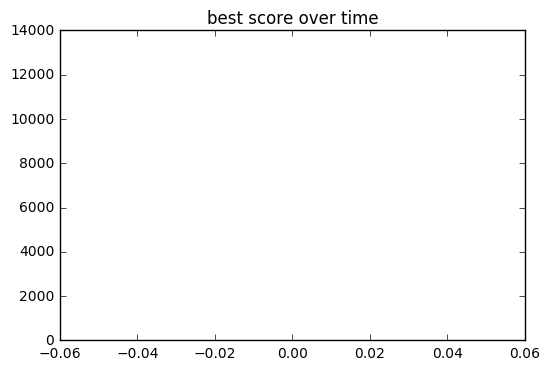

score 8008.14197531 variance 12593.8271605 omitted_pairs 137
wielkości klastrów [283, 9]
pominietych par 137
#BEST CLUSTERING
[{'compounds contained': [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 77, 81, 83, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 117, 118, 119, 122, 123, 125, 126, 127, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 21

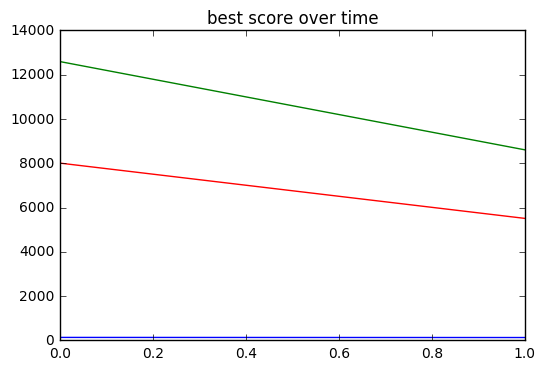

score 5511.82253086 variance 8607.71604938 omitted_pairs 132
wielkości klastrów [284, 13]
pominietych par 132
#BEST CLUSTERING
[{'compounds contained': [0, 1, 2, 3, 4, 5, 6, 9, 12, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 213, 214, 215, 216, 217, 218, 21

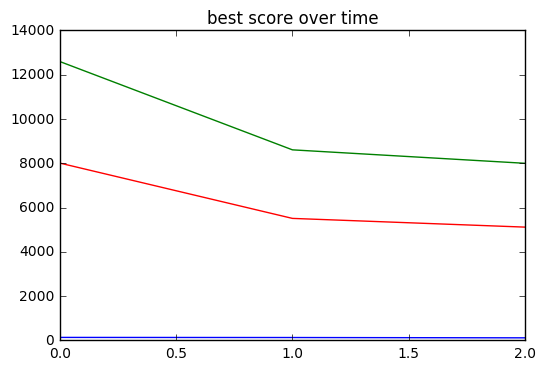

score 5118.19290123 variance 8000.30864198 omitted_pairs 118
wielkości klastrów [296, 15]
pominietych par 118
#BEST CLUSTERING
[{'compounds contained': [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 2

KeyboardInterrupt: 

In [17]:
best_clustering = staszek_folds(similarity_file, all_compounds_file, folder_with_pairs)